In [1]:
import os
import random
import sys
import matplotlib as mpl
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

sys.path.append("../..")

from gemini.utils import *
from drift_detector.rolling_window import *
from baseline_models.temporal.pytorch.optimizer import Optimizer
from baseline_models.temporal.pytorch.utils import *

2022-08-31 09:10:27,181 INFO cyclops.orm     - Database setup, ready to run queries!


In [4]:
PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022"
threshold=0.05
num_timesteps = 6
stat_window=30
lookup_window=30
stride=1
run=1
shift="simulated_deployment"
hospital = ["SBK", "UHNTG", "THPC", "THPM", "UHNTW", "SMH","MSH","PMH"]
outcome="mortality"
aggregation_type="time"
scale=True

In [3]:
admin_data, x, y = get_gemini_data(PATH)

numerical_cols = get_numerical_cols(PATH)
for col in numerical_cols:
    scaler = StandardScaler().fit(x[col].values.reshape(-1, 1))
    x[col] = pd.Series(
        np.squeeze(scaler.transform(x[col].values.reshape(-1, 1))),
        index=x[col].index,
    )
X = reshape_inputs(x, num_timesteps)

2022-08-30 14:25:20,607 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggregated_events.parquet


Load data from aggregated events...


2022-08-30 14:25:21,260 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_start_ts.parquet
2022-08-30 14:25:21,668 INFO cyclops.feature_handler - Loading features from file...
2022-08-30 14:25:21,678 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-30 14:25:21,681 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-30 14:25:21,736 INFO cyclops.feature_handler - Found file to load for temporal features...


Load data from feature handler...


2022-08-30 14:25:27,206 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Load data from admin data...


2022-08-30 14:25:32,919 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_end_ts.parquet
2022-08-30 14:25:47,761 INFO cyclops.feature_handler - Loading features from file...
2022-08-30 14:25:47,765 INFO cyclops.feature_handler - Found file to load for static features...
2022-08-30 14:25:47,767 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-08-30 14:25:47,811 INFO cyclops.feature_handler - Found file to load for temporal features...
2022-08-30 14:25:53,612 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


## Set constant reference distribution

In [4]:
(x_train, y_train), (x_val, y_val), (x_test, y_test), feats, admin_data = import_dataset_hospital(admin_data, x, y, shift, outcome, hospital, run, shuffle=True)

random.seed(1)

# Normalize data
(X_tr_normalized, y_tr),(X_val_normalized, y_val), (X_t_normalized, y_t) = normalize_data(aggregation_type, admin_data, num_timesteps, x_train, y_train, x_val, y_val, x_test, y_test)
# Scale data
if scale:
    X_tr_normalized, X_val_normalized, X_t_normalized = scale_data(numerical_cols, X_tr_normalized, X_val_normalized, X_t_normalized)
# Process data
X_tr_final, X_val_final, X_t_final = process_data(aggregation_type, num_timesteps, X_tr_normalized, X_val_normalized, X_t_normalized)

## Create Data Streams

In [5]:
start_date = date(2019, 1, 1)
end_date = date(2020, 8, 1)

val_ids=list(X_val_normalized.index.get_level_values(0).unique())

In [6]:
x_test_stream, y_test_stream, measure_dates_test = get_streams(x, y, admin_data, start_date, end_date, stride=1, window=1, ids_to_exclude=val_ids)

2019-01-01 - 2019-01-02
2020-01-01 - 2020-01-02


## Rolling Window Drift

In [139]:
dr_technique="BBSDs_trained_LSTM"
model_path=os.path.join(os.getcwd(),"../../saved_models/"+shift+"_lstm.pt")
md_test="MMD"
sign_level=0.05
sample=1000
dataset="gemini"
context_type="rnn"
representation="rnn"

shift_reductor = ShiftReductor(
    X_tr_final, y_tr, dr_technique, dataset, var_ret=0.8, model_path=model_path,
)
# Get shift detector
shift_detector = ShiftDetector(
    dr_technique, md_test, sign_level, shift_reductor, sample, dataset, feats, model_path, context_type, representation,
)

output_dim = 1
batch_size = 64
input_dim = 108
timesteps = 6
hidden_dim = 64
layer_dim = 2
dropout = 0.2
n_epochs = 256
learning_rate = 2e-3
weight_decay = 1e-6
last_timestep_only = False

device = get_device()

model_params = {
    "device": device,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "layer_dim": layer_dim,
    "output_dim": output_dim,
    "dropout_prob": dropout,
    "last_timestep_only": last_timestep_only,
}

model = get_temporal_model("lstm", model_params).to(device)
checkpoint_fpath = os.path.join(os.getcwd(),'../../saved_models/',shift+"_lstm.pt")
model, opt, n_epochs = load_ckp(checkpoint_fpath, model)

In [ ]:
import numpy as np, scipy.stats as st
all_runs = []
for i in range(0,5):
    random.seed(1)
    np.random.seed(1)
    
    dist_test, pvals_test = rolling_window_drift(X_tr_final, x_test_stream, shift_detector, sample, stat_window, lookup_window, stride, num_timesteps, threshold, X_val_final)    
    performance_metrics = rolling_window_performance(x_test_stream, y_test_stream, opt, sample, stat_window, lookup_window, stride, num_timesteps, input_dim, threshold, X_val_final)    
    total_alarms = len(pvals_test[pvals_test<sign_level])
    run_dict = {"dist":dist_test,"pval":pvals_test,"performance":performance_metrics,"alarms":total_alarms}
    all_runs.append(run_dict)
    mean = np.mean(pvals_test[pvals_test<0.05])
    ci = st.t.interval(0.95, len(pvals_test[pvals_test<0.05])-1, loc=np.mean(pvals_test[pvals_test<0.05]), scale=st.sem(pvals_test[pvals_test<0.05]))
    print(total_alarms, " alarms with avg p-value of ", mean, ci)
np.save(os.path.join(PATH, shift, shift+"_rolling_window.npy"), all_runs)

## Plot Drift and Prediction Performance

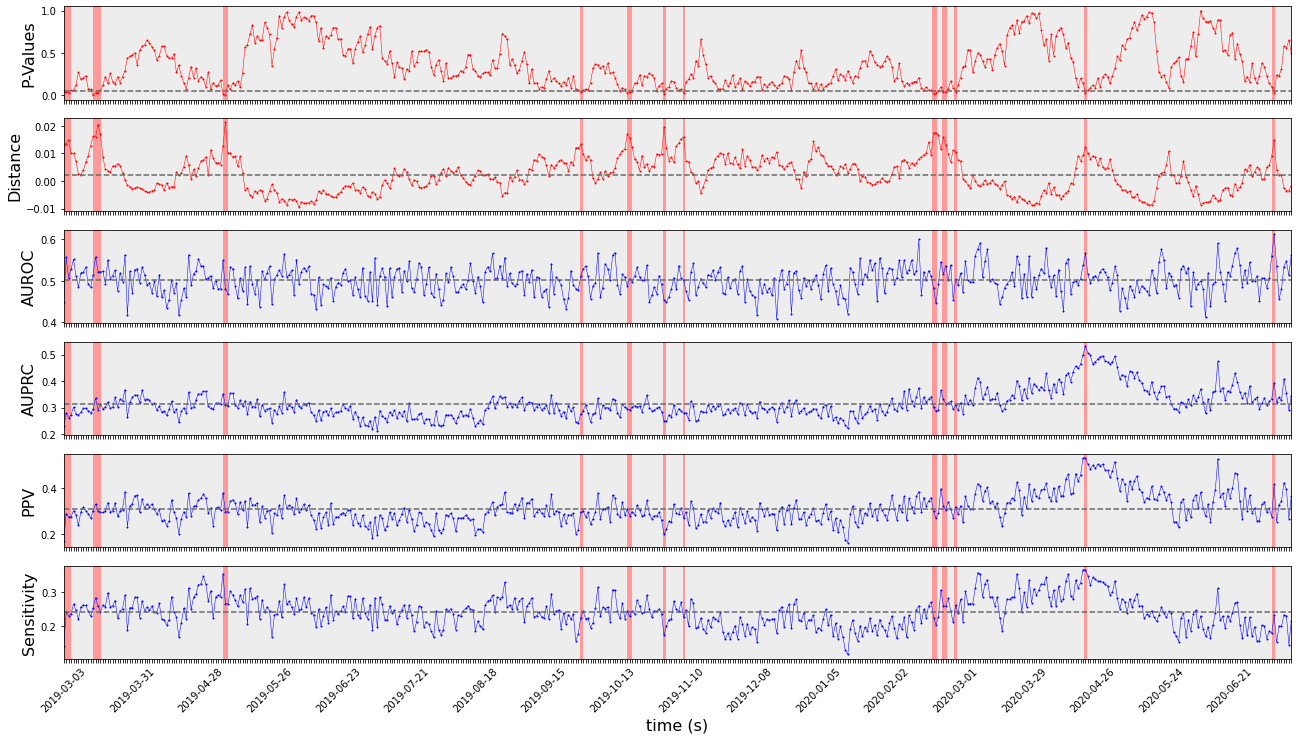

In [40]:
end = performance_metrics.shape[0]
threshold=0.05
measure_dates_test_adjust = [(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=lookup_window+stat_window)).strftime("%Y-%m-%d") for date in measure_dates_test]
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(22,12))
results = pd.DataFrame(
    {'dates': measure_dates_test_adjust[0:end],
     'pval': pvals_test[0:end],
     'dist': dist_test[0:end],
     'detection': np.where(pvals_test[0:end]<threshold,1,0)
    })
results = pd.concat([results,performance_metrics],axis=1)
results.to_pickle(os.path.join(PATH,shift,shift+"_"+dr_technique+"_"+md_test+"_results.pkl")) 
start = 0 
end = performance_metrics.shape[0]-1
cmap = ListedColormap(['lightgrey','red'])
ax1.plot(results['dates'], results['pval'], '.-', color="red", linewidth=0.5, markersize=2)
ax1.set_xlim(results['dates'][start], results['dates'][end])
ax1.axhline(y=threshold, color='dimgrey', linestyle='--')
ax1.set_ylabel('P-Values',fontsize=16)
ax1.set_xticklabels([])
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)
  
ax2.plot(results['dates'], results['dist'], '.-',color="red", linewidth=0.5, markersize=2)
ax2.set_xlim(results['dates'][start], results['dates'][end])
ax2.set_ylabel('Distance',fontsize=16)
ax2.axhline(y=np.mean(results['dist']), color='dimgrey', linestyle='--')
ax2.set_xticklabels([])
ax2.pcolorfast(ax2.get_xlim(), ax2.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)

ax3.plot(results['dates'], results['auroc'], '.-',color="blue", linewidth=0.5, markersize=2)
ax3.set_xlim(results['dates'][start], results['dates'][end])
ax3.set_ylabel('AUROC', fontsize=16)
ax3.axhline(y=np.mean(results['auroc']), color='dimgrey', linestyle='--')
ax3.set_xticklabels([])
ax3.pcolorfast(ax3.get_xlim(), ax3.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)

ax4.plot(results['dates'], results['auprc'], '.-',color="blue", linewidth=0.5, markersize=2)
ax4.set_xlim(results['dates'][start], results['dates'][end])
ax4.set_ylabel('AUPRC',fontsize=16)
ax4.axhline(y=np.mean(results['auprc']), color='dimgrey', linestyle='--')
ax4.set_xticklabels([])
ax4.pcolorfast(ax4.get_xlim(), ax4.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)

ax5.plot(results['dates'], results['prec1'], '.-',color="blue", linewidth=0.5, markersize=2)
ax5.set_xlim(results['dates'][start], results['dates'][end])
ax5.set_ylabel('PPV', fontsize=16)
ax5.axhline(y=np.mean(results['prec1']), color='dimgrey', linestyle='--')
ax5.set_xticklabels([])
ax5.pcolorfast(ax5.get_xlim(), ax5.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)

ax6.plot(results['dates'], results['rec1'], '.-',color="blue", linewidth=0.5, markersize=2)
ax6.set_xlim(results['dates'][start], results['dates'][end])
ax6.set_ylabel('Sensitivity',fontsize=16)
ax6.set_xlabel('time (s)', fontsize=16)
ax6.axhline(y=np.mean(results['rec1']), color='dimgrey', linestyle='--')
ax6.tick_params(axis='x', labelrotation=45)
ax6.pcolorfast(ax6.get_xlim(), ax6.get_ylim(),results['detection'].values[np.newaxis], cmap = cmap, alpha = 0.4)

for index, label in enumerate(ax6.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()

## Retraining: Drift Alarms 

### Drift Alarms

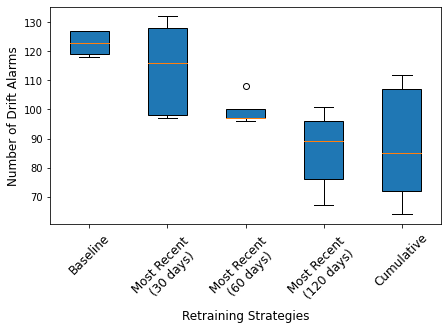

In [30]:
baseline = [127, 118, 119, 123, 127]
mostrecent30 = [132, 116, 97, 98, 128]
mostrecent60 = [100, 96, 108, 97, 97]
mostrecent120 = [96, 76, 101, 67, 89]
cumulative = [72, 112, 64, 85, 107]

retraining_drift = pd.DataFrame({'Baseline': baseline, 
                           'Most Recent \n(30 days)': mostrecent30,
                          'Most Recent \n(60 days)': mostrecent60, 
                           'Most Recent \n(120 days)': mostrecent120, 
                          'Cumulative': cumulative})
fig, ax = plt.subplots(figsize=(7, 4))
ax.boxplot(retraining_drift, patch_artist=True)
ax.set_xticks([1, 2, 3,4,5], retraining_drift.columns, rotation=45, fontsize=12)
ax.set_xlabel('Retraining Strategies', fontsize=12)
ax.set_ylabel('Number of Drift Alarms', fontsize=12)
plt.show()

### Number of Epochs

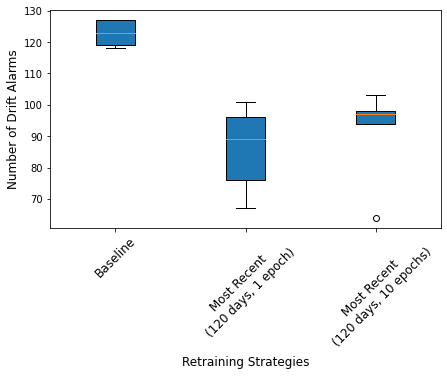

In [31]:
baseline = [127, 118, 119, 123, 127]
mostrecent120 = [96, 76, 101, 67, 89]
mostrecent120_10 = [97, 103, 98, 64, 94]

retraining_drift = pd.DataFrame({'Baseline': baseline, 
                           'Most Recent \n(120 days, 1 epoch)': mostrecent120, 
                          'Most Recent\n (120 days, 10 epochs)': mostrecent120_10})
fig, ax = plt.subplots(figsize=(7, 4))
ax.boxplot(retraining_drift, patch_artist=True)
ax.set_xticks([1, 2, 3], retraining_drift.columns, rotation=45, fontsize=12)
ax.set_xlabel('Retraining Strategies', fontsize=12)
ax.set_ylabel('Number of Drift Alarms', fontsize=12)
plt.show()

### Drift Threshold

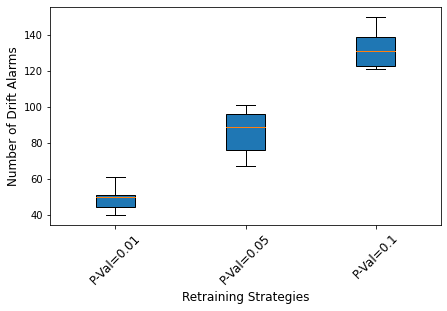

In [37]:
mostrecent120_10_2 = [50, 44, 40, 51, 61]
mostrecent120 = [96, 76, 101, 67, 89]
mostrecent120_10_1 = [121, 150, 123, 139, 131]

retraining_drift = pd.DataFrame({
                        'P-Val=0.01': mostrecent120_10_2, 
                           'P-Val=0.05': mostrecent120, 
                          'P-Val=0.1': mostrecent120_10_1})
fig, ax = plt.subplots(figsize=(7, 4))
ax.boxplot(retraining_drift, patch_artist=True)
ax.set_xticks([1, 2, 3], retraining_drift.columns, rotation=45, fontsize=12)
ax.set_xlabel('Retraining Strategies', fontsize=12)
ax.set_ylabel('Number of Drift Alarms', fontsize=12)
plt.show()

## Retraining: PPV & Sensitivity

### Window Size

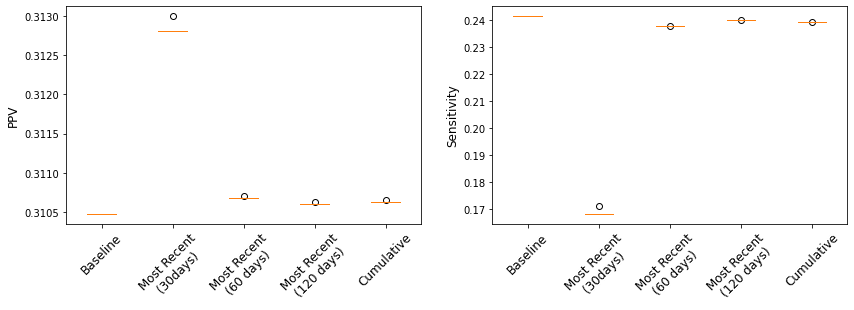

In [46]:
types = ['baseline','mostrecent30','mostrecent60','mostrecent120','cumulative_1epoch']
labels = ['Baseline','Most Recent\n(30days)','Most Recent\n(60 days)','Most Recent\n(120 days)','Cumulative']

drift_sensitivity = []
drift_ppv = []
for retraining_type in types:
    for i in range(0,5):
        res_path=os.path.join(PATH, shift, shift+"_"+retraining_type+"_retraining_update.npy")
        cum = np.load(res_path,allow_pickle=True)[i]
        drift_sensitivity.append(np.mean(cum['performance']['rec1']))
        drift_ppv.append(np.mean(cum['performance']['prec1']))
        #drift_sensitivity.append(np.mean(cum['performance']['rec1'][[i for i,v in enumerate(cum['pval']) if v < 0.05]]))
        #drift_ppv.append(np.mean(cum['performance']['prec1'][[i for i,v in enumerate(cum['pval']) if v < 0.05]]))    

retraining_drift = pd.DataFrame({'Retraining Strategy': np.repeat(types,5), 
                           'PPV': drift_ppv,
                          'Sensitivity': drift_sensitivity})

fig, axs = plt.subplots(1, 2, figsize=(14,4))
for j, variable in enumerate(['PPV','Sensitivity']):
    for i, grp in enumerate(retraining_drift.groupby('Retraining Strategy')):
        axs[j].boxplot(x=variable, data=grp[1], positions=[i],widths=0.4, patch_artist=True)
        axs[j].set_xticks(range(0,len(types)), labels,rotation=45, fontsize=12)
        axs[j].set_ylabel(variable, fontsize=12)
plt.show()

### Number of Epochs

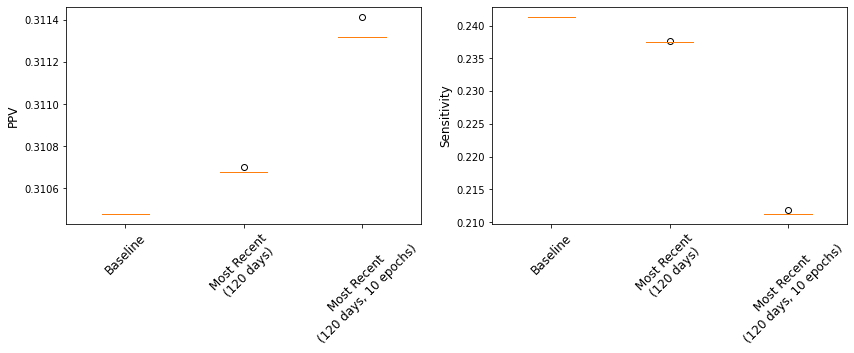

In [39]:
types= ['baseline','mostrecent120','mostrecent120_10epochs']
labels= ['Baseline','Most Recent\n(120 days)','Most Recent\n(120 days, 10 epochs)']

drift_sensitivity = []
drift_ppv = []
for retraining_type in types:
    for i in range(0,5):
        res_path=os.path.join(PATH, shift, shift+"_"+retraining_type+"_retraining_update.npy")
        cum = np.load(res_path,allow_pickle=True)[i]
        drift_sensitivity.append(np.mean(cum['performance']['rec1']))
        drift_ppv.append(np.mean(cum['performance']['prec1']))
        #drift_sensitivity.append(np.mean(cum['performance']['rec1'][[i for i,v in enumerate(cum['pval']) if v < 0.05]]))
        #drift_ppv.append(np.mean(cum['performance']['prec1'][[i for i,v in enumerate(cum['pval']) if v < 0.05]]))    

retraining_drift = pd.DataFrame({'Retraining Strategy': np.repeat(types,5), 
                           'PPV': drift_ppv,
                          'Sensitivity': drift_sensitivity})

fig, axs = plt.subplots(1, 2, figsize=(14,4))
for j, variable in enumerate(['PPV','Sensitivity']):
    for i, grp in enumerate(retraining_drift.groupby('Retraining Strategy')):
        axs[j].boxplot(x=variable, data=grp[1], positions=[i],widths=0.4, patch_artist=True)
        axs[j].set_xticks(range(0,len(types)), labels,rotation=45, fontsize=12)
        axs[j].set_ylabel(variable, fontsize=12)
plt.show()

### Drift Threshold

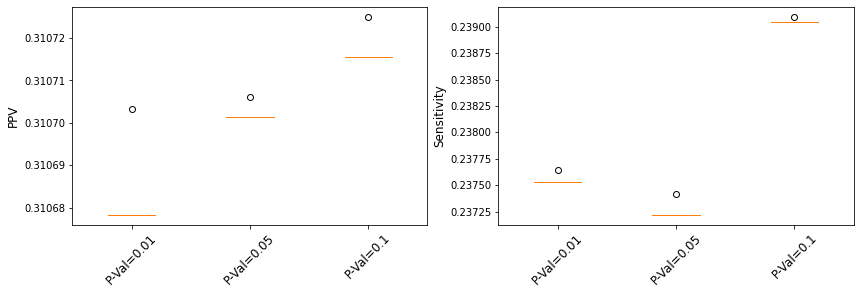

In [40]:
types= ['mostrecent120_1epoch_pval0.01', 'mostrecent120','mostrecent120_1epoch_pval0.1']
labels= ['P-Val=0.01','P-Val=0.05','P-Val=0.1']

drift_sensitivity = []
drift_ppv = []
for retraining_type in types:
    for i in range(0,5):
        res_path=os.path.join(PATH, shift, shift+"_"+retraining_type+"_retraining_update.npy")
        cum = np.load(res_path,allow_pickle=True)[i]
        drift_sensitivity.append(np.mean(cum['performance']['rec1']))
        drift_ppv.append(np.mean(cum['performance']['prec1']))
        #drift_sensitivity.append(np.mean(cum['performance']['rec1'][[i for i,v in enumerate(cum['pval']) if v < 0.05]]))
        #drift_ppv.append(np.mean(cum['performance']['prec1'][[i for i,v in enumerate(cum['pval']) if v < 0.05]]))    

retraining_drift = pd.DataFrame({'Retraining Strategy': np.repeat(types,5), 
                           'PPV': drift_ppv,
                          'Sensitivity': drift_sensitivity})

fig, axs = plt.subplots(1, 2, figsize=(14,4))
for j, variable in enumerate(['PPV','Sensitivity']):
    for i, grp in enumerate(retraining_drift.groupby('Retraining Strategy')):
        axs[j].boxplot(x=variable, data=grp[1], positions=[i],widths=0.4, patch_artist=True)
        axs[j].set_xticks(range(0,len(types)), labels,rotation=45, fontsize=12)
        axs[j].set_ylabel(variable, fontsize=12)
plt.show()

## Relationship between Performance and Drift P-Value

Pearsons correlation: 0.146 P-Value: 0.001
Spearmans correlation: 0.141 P-Value: 0.002


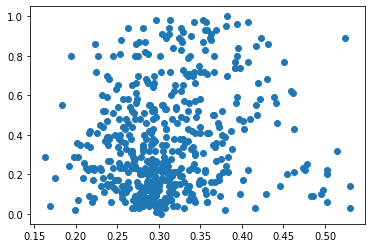

In [264]:
# calculate Pearson's correlation
pcorr, pcorr_pval = pearsonr(results['prec1'], results['pval'])
print('Pearsons correlation: %.3f P-Value: %.3f' % (pcorr, pcorr_pval))
# calculate spearman's correlation
scorr, scorr_pval = spearmanr(results['prec1'], results['pval'])
print('Spearmans correlation: %.3f P-Value: %.3f' % (scorr, scorr_pval))
# plot
plt.scatter(results['prec1'], results['pval'])
plt.show()

Pearsons correlation: -0.370 P-Value: 0.000
Spearmans correlation: -0.400 P-Value: 0.000


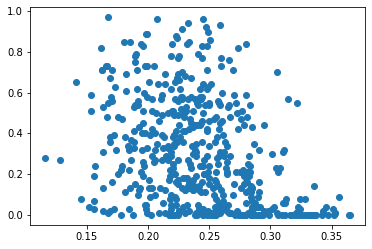

In [36]:
# calculate Pearson's correlation
pcorr, pcorr_pval = pearsonr(results['rec1'], results['pval'])
print('Pearsons correlation: %.3f P-Value: %.3f' % (pcorr, pcorr_pval))
# calculate spearman's correlation
scorr, scorr_pval = spearmanr(results['rec1'], results['pval'])
print('Spearmans correlation: %.3f P-Value: %.3f' % (scorr, scorr_pval))
# plot
plt.scatter(results['rec1'], results['pval'])
plt.show()